# Guessing whether a sample set drawn from Gaussian is shifted

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

<IPython.core.display.Javascript object>


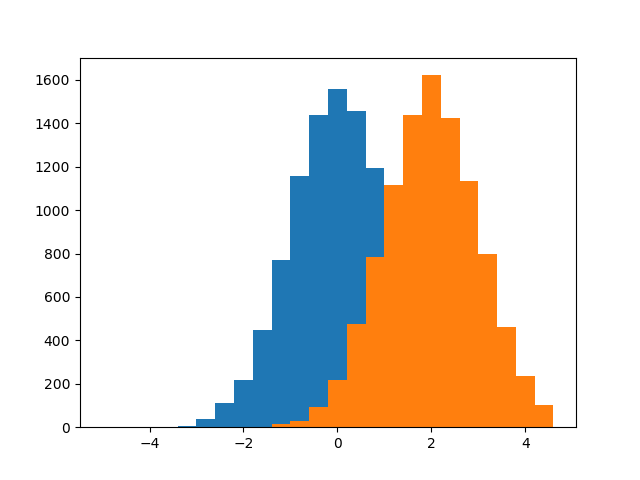

In [12]:
sigma=2
scale=0.2
A=np.random.normal(size=[10000,2])
A[:,1]+=sigma
t=plt.hist(A[:,0], bins=np.arange(-5,5,scale*sigma))
t=plt.hist(A[:,1], bins=np.arange(-5,5,scale*sigma))

Define offset

In [3]:
test_offset=0.02
samples=100

Generate X and Y

In [4]:
def get_some_data(copies, dim, offset):
    Y=np.random.uniform(size=[copies,1])>0.5
    mult=np.ones((1,dim))*offset
    X=np.random.normal(size=[copies, dim], scale=0.1)
    X+=np.matmul(Y,mult)
    Y=Y
    return (X,Y.astype(int).flatten())

Setup tf

In [62]:
def original_network(x):
    xflat=tf.contrib.layers.flatten(x)
    layerA=tf.contrib.layers.fully_connected(xflat,10)
    #layerA=tf.layers.dense(xflat, 10, activation=tf.nn.relu, name='First Layer')
    layerB=tf.contrib.layers.fully_connected(layerA, 5)
    return tf.contrib.layers.fully_connected(layerB,1)

In [63]:
def test_network(x):
    xflat=tf.contrib.layers.flatten(x)
    layerA=tf.contrib.layers.fully_connected(xflat,10)
    batchNormA=tf.contrib.layers.batch_norm(layerA, center=True, scale=True, is_training=phase)
    layerB=tf.contrib.layers.fully_connected(batchNormA, 10)
    layerC=tf.contrib.layers.fully_connected(layerB, 5)
    return tf.contrib.layers.fully_connected(layerC,1)

In [64]:
def new_network(x):
    xflat=tf.contrib.layers.flatten(x)
    layerA=tf.contrib.layers.fully_connected(xflat,200)
    layerB=tf.contrib.layers.fully_connected(layerA,50)
    layerC=tf.contrib.layers.fully_connected(layerB,10)
    layerD=tf.contrib.layers.fully_connected(layerC,5)
    return tf.contrib.layers.fully_connected(layerD,1)

In [65]:
x=tf.placeholder(dtype=tf.float32, shape=[None, samples])
y=tf.placeholder(dtype=tf.int32, shape=[None])
phase=tf.placeholder(dtype=tf.bool)

logits=original_network(x)

#Setup loss calculation, start with squared error
YF=tf.cast(y,tf.float32)
YF=tf.reshape(YF, shape=[tf.shape(YF)[0], 1])
diff=tf.subtract(logits, YF)
LS=tf.multiply(diff,diff)
#Then do regularization
regMult=tf.multiply(logits,tf.subtract(1.0,logits))
logitsN=tf.multiply(tf.abs(regMult), 0.75)
#Add them together
loss=tf.add(tf.reduce_mean(LS), tf.reduce_mean(logitsN))
#loss=tf.reduce_mean(LS)
train_op=tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)


correct_pred=tf.round(logits)
accuracy=tf.reduce_mean(tf.abs(tf.subtract(correct_pred, YF)))

In [30]:
tf.set_random_seed(123456)
sess=tf.Session()

sess.run(tf.global_variables_initializer())

(X,Y)=get_some_data(1000,samples, test_offset)
results=0
for i in range(4000):
    if (i%1000<=999):
        (X,Y)=get_some_data(1000,samples, test_offset)    
    _,results, LN,losses,layer1=sess.run([train_op, logits, accuracy, loss, layerA], feed_dict={x:X, y:Y, phase:True})
    if (i%1000==0):
        print("Error rate: ", LN)
        #print(LN.shape[0],",",LN.shape[1])
        #print(LN.shape[0])
        print("Real loss: ",losses)
        

Error rate:  0.468
Real loss:  0.457127
Error rate:  0.154
Real loss:  0.156489
Error rate:  0.15
Real loss:  0.152015
Error rate:  0.172
Real loss:  0.169935


Truth:  0  Guess:  [ 0.]  Mean:  -9.72945023542e-05


719

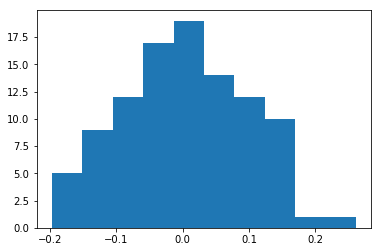

In [31]:
plt.figure()
idx=np.random.randint(0,1000)
t=plt.hist(X[idx, :])
print("Truth: ",Y[idx], " Guess: ", results[idx], " Mean: ", np.mean(X[idx,:]))
idx

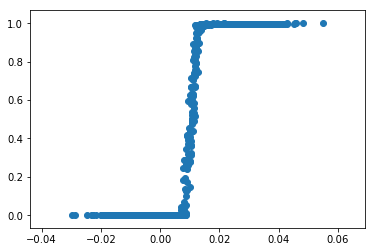

In [21]:
mn=np.mean(X, axis=1)
plt.scatter(mn, results)
mn_guess=mn>(test_offset/2)

In [516]:
np.sum(np.abs(mn_guess-Y))

138

In [40]:
my_guess=np.round(results)
np.sum(np.abs(my_guess-Y.reshape(1000,1)))

486.0

(array([  6.21600000e+03,   2.35700000e+03,   9.01000000e+02,
          3.05000000e+02,   1.32000000e+02,   5.90000000e+01,
          1.90000000e+01,   8.00000000e+00,   1.00000000e+00,
          2.00000000e+00]),
 array([  2.36915917e-07,   1.23030402e-03,   2.46037112e-03,
          3.69043822e-03,   4.92050533e-03,   6.15057243e-03,
          7.38063953e-03,   8.61070664e-03,   9.84077374e-03,
          1.10708408e-02,   1.23009079e-02]),
 <a list of 10 Patch objects>)

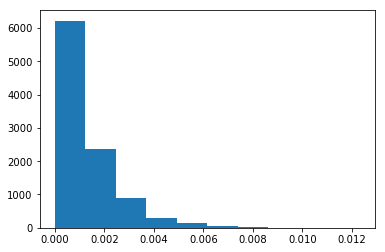

In [85]:
plt.hist(np.random.pareto(800,size=[10000,1]))